In [1]:
import pygplates
import sys
import numpy as np
sys.path.append('../../GPlatesClassStruggle')
sys.path.append('../../atom_utils')
sys.path.append('../../passive_margins/')
from raster_reconstruction_classes import *
import matplotlib.pyplot as plt
#from reconstruct_atom_rasters import *
#import points_spatial_tree
#import points_in_polygons
#import paleogeography as pg
#import tectonic_subsidence as ts 

%matplotlib inline
%load_ext autoreload
%autoreload 2

from grdbacktrack import *


agegrid = GplatesRaster('../data/agegrid_final_mask_0.nc')

topography = GplatesRaster('../data/ETOPO1_0.1.grd')

anomalous_ocean = GplatesRaster('../data/Wessel_lip_seamount_mask.nc')

sediment_thickness = GplatesRaster('../data/sedthick_world_v3_5min_epsg4326_cf.nc')


rotation_filename = '../../agegrid-dev/input_files/Rotations/Matthews_etal_GPC_2016_410-0Ma_GK07.rot'

# Note: must be static polygons that have the conjugate plateid assigned
static_polygon_filename = '../../passive_margins/input_data/StaticPolygons/Global_EarthByte_GPlates_PresentDay_StaticPlatePolygons_2015_v1.shp'

rotation_model = pygplates.RotationModel(rotation_filename)
static_polygon_features = pygplates.FeatureCollection(static_polygon_filename)


In [57]:
points, point_plate_pairs, point_ages = sample_seafloor_age_model(static_polygon_features, 
                                                                  agegrid, 
                                                                  128)


working on plate pair [201, 701]
working on plate pair [201, 714]
working on plate pair [101, 714]
working on plate pair [101, 304]
working on plate pair [101, 317]
working on plate pair [101, 301]
working on plate pair [102, 301]
working on plate pair [102, 907]
working on plate pair [301, 977]
working on plate pair [102, 101]
working on plate pair [201, 802]
working on plate pair [802, 501]
working on plate pair [802, 511]
working on plate pair [801, 511]
working on plate pair [802, 701]
working on plate pair [701, 750]
working on plate pair [701, 293]
working on plate pair [750, 293]
working on plate pair [701, 702]
working on plate pair [701, 501]
working on plate pair [702, 704]
working on plate pair [704, 501]
working on plate pair [801, 802]
working on plate pair [802, 514]
working on plate pair [801, 501]
working on plate pair [801, 833]
working on plate pair [804, 901]
working on plate pair [814, 901]
working on plate pair [901, 911]
working on plate pair [901, 909]
working on

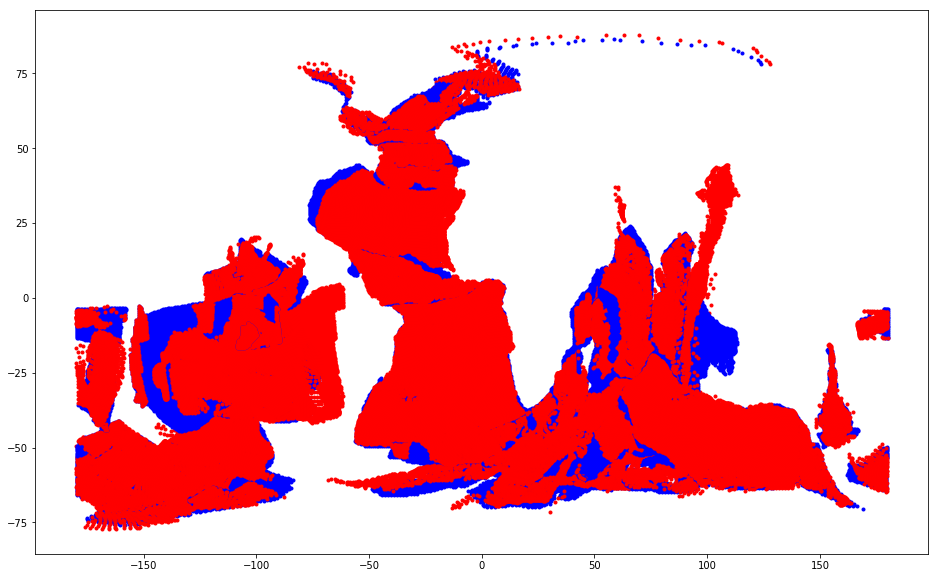

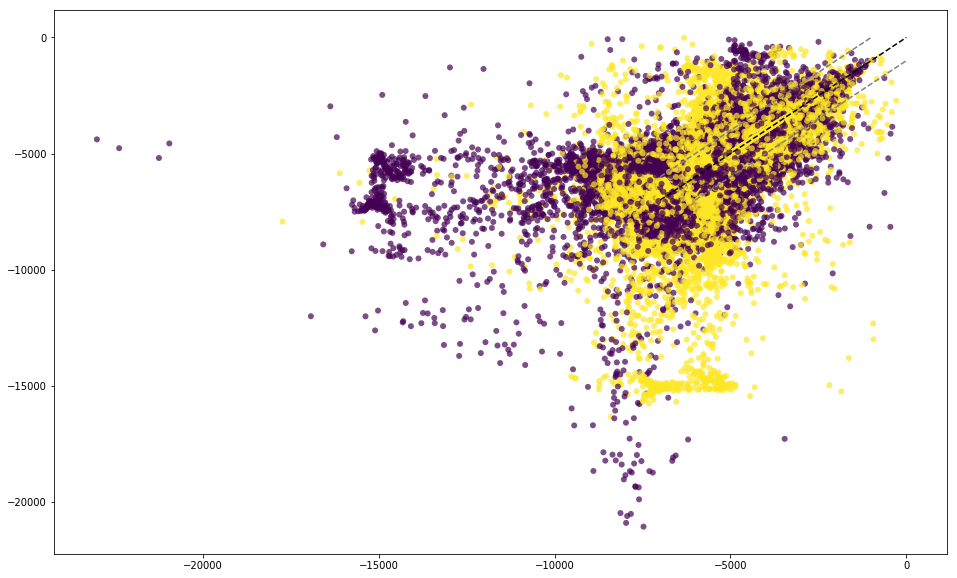

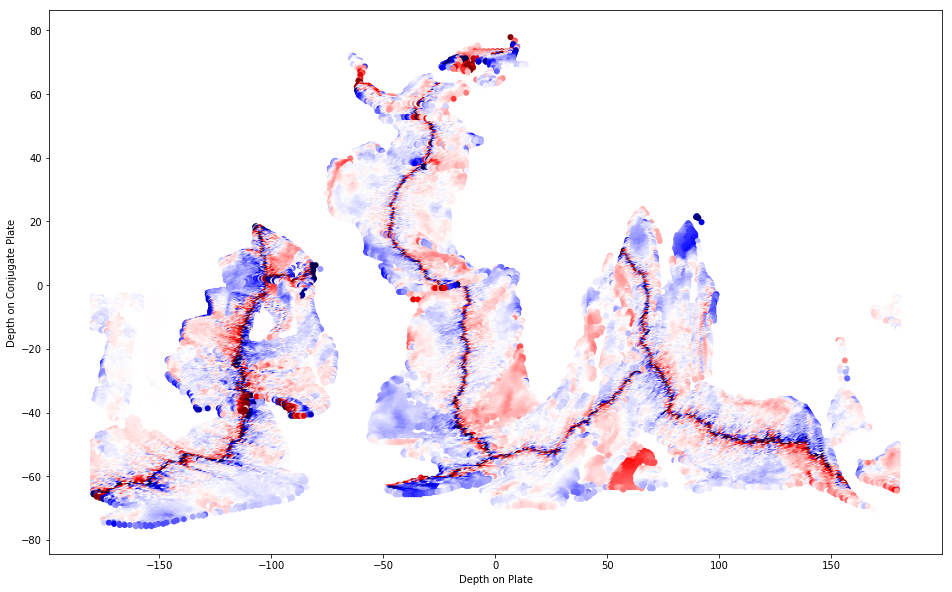

In [70]:
# the returned object is  list of lists, where each list entry contains
# a list for one point, with 6 values
# longitude, latitude, conjugate_longitude, conjugate_latitude, plate_id, seafloor_age


list_of_plate_pairs = [[201,701],
                       [201,714],
                       [101,714],
                       [101,304],
                       [101,317],
                       [101,301],
                       [102,301],
                       [102,907],
                       [301,977],
                       [102,101],
                       [201,802],
                       [802,501],
                       [802,511],
                       [801,511],
                       [802,701],
                       [701,750],
                       [701,293],
                       [750,293],
                       [701,702],
                       [701,501],
                       [702,704],
                       [702,802],
                       [704,501],
                       [801,802],
                       [802,514],
                       [801,501],
                       [801,833],
                       [801,901],
                       [804,901],
                       [814,901],
                       [901,911],
                       [901,909],
                       [909,911],
                       [911,971],
                       [971,972],
                       [982,983],
                       [981,982]]



point_longitudes_all = []
point_latitudes_all = []
point_plate_ids_all = []
point_seafloor_ages_all = []
point_depth_all = []
point_depth_mask_all = []
anomalous_subsidence_rate_all = []

fig1 = plt.figure(figsize=(16,10))
ax1 = fig1.add_subplot(1, 1, 1)
fig2 = plt.figure(figsize=(16,10))
ax2 = fig2.add_subplot(1, 1, 1)
fig3 = plt.figure(figsize=(16,10))
ax3 = fig3.add_subplot(1, 1, 1)

for target_plate_pair in list_of_plate_pairs:
    
    print 'working on plate pair %s' % target_plate_pair

    # 
    points_and_conjugate_points = return_conjugate_points(points, 
                                                          point_ages, 
                                                          point_plate_pairs,
                                                          target_plate_pair,
                                                          rotation_model)

    # give the output more human-readable names
    point_longitudes = np.array(zip(*points_and_conjugate_points)[0])
    point_latitudes = np.array(zip(*points_and_conjugate_points)[1])
    conjugate_longitudes = np.array(zip(*points_and_conjugate_points)[2])
    conjugate_latitudes = np.array(zip(*points_and_conjugate_points)[3])
    point_plate_ids = np.array(zip(*points_and_conjugate_points)[4])
    point_seafloor_ages = np.array(zip(*points_and_conjugate_points)[5])


    # this plot checks to see that the points (blue) and their conjugates (rec)
    # all plot on top of one another, which they should do for us to be sampling grids
    # correctly

    point_depth = get_unloaded_bsmt_depth(point_longitudes,point_latitudes,topography,sediment_thickness)    
    conj_point_depth = get_unloaded_bsmt_depth(conjugate_longitudes,conjugate_latitudes,topography,sediment_thickness)

    point_depth_mask = anomalous_ocean.sample_using_gmt(point_longitudes,point_latitudes)    
    conj_point_depth_mask = anomalous_ocean.sample_using_gmt(conjugate_longitudes,conjugate_latitudes)
    mask = np.any(np.vstack((point_depth_mask,conj_point_depth_mask)),axis=0)


    a2d = pg.age2depth(point_seafloor_ages)

    asymmetric_residual_basement_depth = point_depth - a2d
    symmetric_residual_basement_depth = np.mean(np.vstack((point_depth,conj_point_depth)),axis=0) - a2d


    # the term anomalous subsidence is used to describe the different between the expected depth based
    # on age depth relationship and the the depth we need will impose to ensure the ocean basin
    # always looks symmetric
    # We 'know' the anomalous subsidence at two times:
    # 1. present-day
    # 2. The birth time of the point and its conjugate
    # Values in between are derived by linear interpolation

    # Example:
    # suppose point A lies on 50 Ma crust, and has a residual topography at present-day of +500m
    # its conjugate (point B) has a residual topography of +100m
    # --> at 50 Ma, we assume the MOR depth was 300 m above 'normal' (which is 2600m?)
    # --> assume that the 'anomalous' depth for point A changes linearly from 500m to 300m between 0Ma and 50Ma
    # --> 'anomalous' depth for point A changes linearly from 100m to 300m between 0Ma and 50Ma

    # --> Rate of anomalous subsidence - positive values mean the residual depth has been increasing through time (greater now than in the past)
    anomalous_subsidence_rate = (asymmetric_residual_basement_depth - symmetric_residual_basement_depth) / np.array(zip(*points_and_conjugate_points)[5])

    ax1.plot(point_longitudes,point_latitudes,'b.')
    ax1.plot(conjugate_longitudes,conjugate_latitudes,'r.')
    
    ax2.scatter(point_depth[~mask],conj_point_depth[~mask],c=point_plate_ids[~mask],edgecolors='',alpha=0.7)

    ax3.scatter(point_longitudes[~mask],
                 point_latitudes[~mask],
                 c=anomalous_subsidence_rate[~mask],
                 edgecolors='',vmin=-100,vmax=100,
                 cmap=plt.cm.seismic)
    
    point_longitudes_all.append(point_longitudes)
    point_latitudes_all.append(point_latitudes)
    point_plate_ids_all.append(point_plate_ids)
    point_seafloor_ages_all.append(point_seafloor_ages)
    point_depth_all.append(point_depth)
    point_depth_mask_all.append(point_depth_mask)
    anomalous_subsidence_rate_all.append(anomalous_subsidence_rate)

    
fig1.show()

ax2.plot([-7000,0],[-7000,0],'k--')
ax2.plot([-7000,-1000],[-6000,0],'--',color='gray')
ax2.plot([-6000,0],[-7000,-1000],'--',color='gray')
plt.xlabel('Depth on Plate')
plt.ylabel('Depth on Conjugate Plate')
#plt.colorbar()
fig2.show()

#ax3.colorbar()
fig3.show()




[101 102 201 293 301 304 317 501 511 514 701 702 704 714 750 801 802 804
 814 833 901 909 911 971 972 981 982 983]


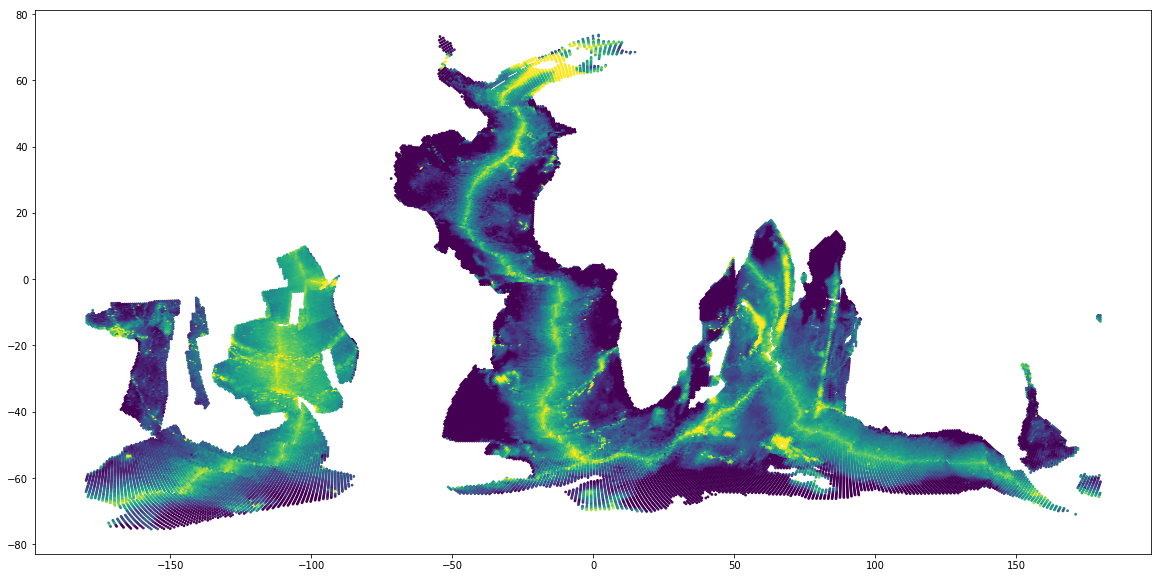

In [71]:

########################################################
recon_time = 15.
anchor_plate_id = 0

# expected depth at present
a2d_present = pg.age2depth(np.hstack(point_seafloor_ages_all))

# expected depth at reconstruction time
a2d_recon = pg.age2depth(np.hstack(point_seafloor_ages_all) - recon_time)

# expected subsidence between present and reconstruction time
expected_subsidence = a2d_recon - a2d_present

anomalous_subsidence_at_recon_time = np.hstack(anomalous_subsidence_rate_all) * recon_time

total_subsidence = expected_subsidence - anomalous_subsidence_at_recon_time

backtracked_depth = np.hstack(point_depth_all) + total_subsidence


unique_plate_ids = np.unique(np.hstack(point_plate_ids_all))

print unique_plate_ids

reconstructed_lons = []
reconstructed_lats = []
reconstructed_depths = []
reconstructed_masks = []

for plate_id in unique_plate_ids:
    
    finite_rotation = rotation_model.get_rotation(float(recon_time), 
                                                  plate_id, 
                                                  0, 
                                                  anchor_plate_id)
    
    index = np.equal(np.hstack(point_plate_ids_all),plate_id)
    mulitpoint = pygplates.MultiPointOnSphere(zip(np.hstack(point_latitudes_all)[index],
                                                  np.hstack(point_longitudes_all)[index]))
    reconstructed_points = finite_rotation * mulitpoint

    reconstructed_lons.append(reconstructed_points.to_lat_lon_array()[:,1])
    reconstructed_lats.append(reconstructed_points.to_lat_lon_array()[:,0])
    reconstructed_depths.append(backtracked_depth[index])
    reconstructed_masks.append(np.hstack(point_depth_mask_all)[index])

#new_mask=np.logical_not(np.hstack(reconstructed_masks))
new_mask = np.where(np.ones(np.hstack(reconstructed_depths).shape))


plt.figure(figsize=(20,10))
plt.scatter(np.hstack(reconstructed_lons)[new_mask],
            np.hstack(reconstructed_lats)[new_mask],
            c=np.hstack(reconstructed_depths)[new_mask],
            s=3,
            vmin=-6000,vmax=-2000)


Reconstruct static polygons...
Find static polygons...
Group by polygons...
Reverse reconstruct points...
Sample present-day grid...


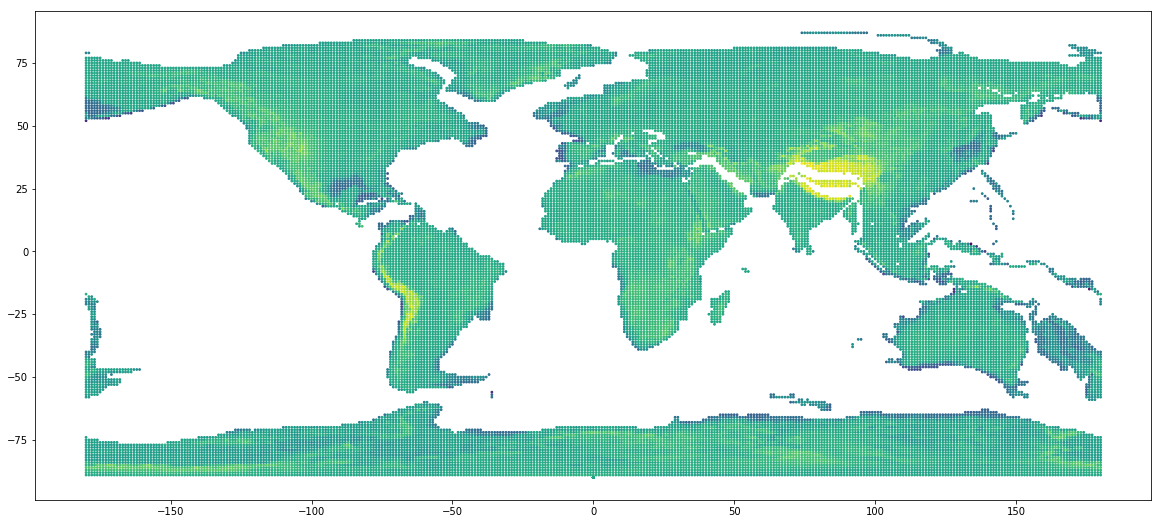

In [72]:
from reconstruct_atom_rasters import *

from_time = 0.
to_time = recon_time

continent_polygons = '/Users/Simon/GIT/gplates-web-service/django/GWS/DATA/MODELS/MULLER2016/Matthews_etal_GPC_2016_ContinentalPolygons.gpmlz'


(reconstructed_topography_point_lons,
 reconstructed_topography_point_lats,
 reconstructed_topography_points_z) = reconstruct_raster(topography, continent_polygons, rotation_model,
                                                         from_time, to_time, grid_sampling=1.0)

plt.figure(figsize=(20,9))
plt.scatter(reconstructed_topography_point_lons,reconstructed_topography_point_lats,
            c=reconstructed_topography_points_z,s=3)
plt.show()


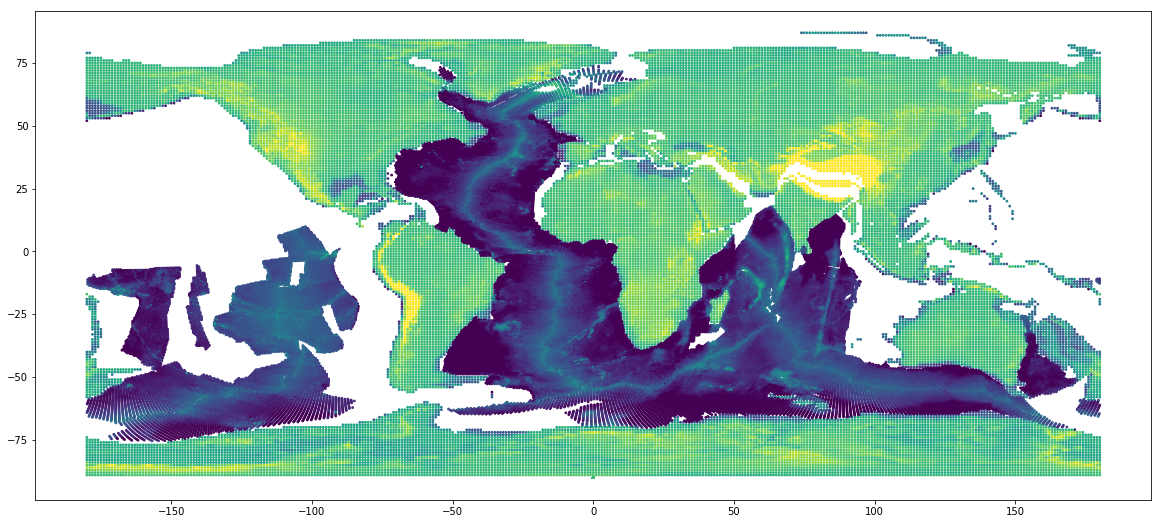

In [73]:
plt.figure(figsize=(20,9))
plt.scatter(reconstructed_topography_point_lons,
            reconstructed_topography_point_lats,
            c=reconstructed_topography_points_z,
            s=3,
            vmin=-6000,vmax=3000)

plt.scatter(np.hstack(reconstructed_lons)[new_mask],
            np.hstack(reconstructed_lats)[new_mask],
            c=np.hstack(reconstructed_depths)[new_mask],
            s=3,
            vmin=-6000,vmax=3000)

plt.show()


In [ ]:
#TODO
# Add sediments back in
# Do something about crust with no conjugate
# Do something about completely synthetic crust
# Do something about passive margin subsidence backtracking
